## Forecasting with ARIMA in R

https://www.datascience.com/blog/introduction-to-forecasting-with-arima-in-r-learn-data-science-tutorials

## Step 1: Load R Packages 
We start out by loading the necessary R packages and reading in the analysis dataset. Here we are using a dataset on the number of bicycles checkouts from a bike sharing service, which is available as part of the UCI Machine Learning Repository. We will be using the dataset aggregated at daily level. 

In [3]:
library('ggplot2')
library('forecast')
library('tseries')

In [10]:
daily_data = read.csv("data/BikeSharing/day.csv", header=TRUE, stringsAsFactors=FALSE)

## Step 2: Examine Your Data

A good stating point is to plot the series and visually examine it for any outliers, volatility, or irregularities. In this case, bicycle checkouts are showing a lot of fluctuations from one day to another. However, even with this volatility present, we already see some patterns emerge. For example, lower usage of bicycles occurs in the winter months and higher checkout numbers are observed in the summer months:

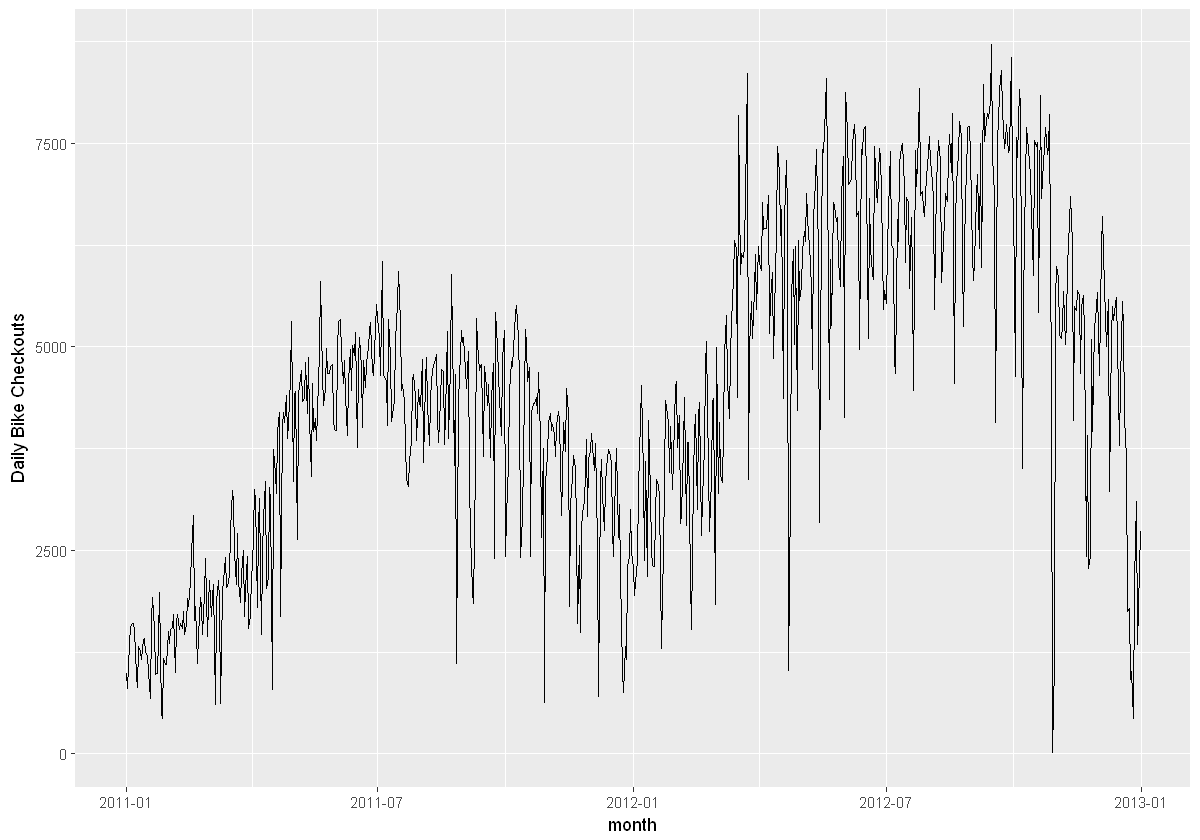

In [34]:
daily_data$Date = as.Date(daily_data$dteday)

options(repr.plot.width = 10, repr.plot.heights = 1)
ggplot(daily_data, aes(Date, cnt)) + geom_line() + scale_x_date('month')  + ylab("Daily Bike Checkouts") + xlab("")

In some cases, the number of bicycles checked out dropped below 100 on day and rose to over 4,000 the next day. These are suspected outliers that could bias the model by skewing statistical summaries. R provides a convenient method for removing time series outliers: tsclean() as part of its forecast package. tsclean() identifies and replaces outliers using series smoothing and decomposition. This method is also capable of inputing missing values in the series if there are any.

Note that we are using the ts() command to create a time series object to pass to tsclean():

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.


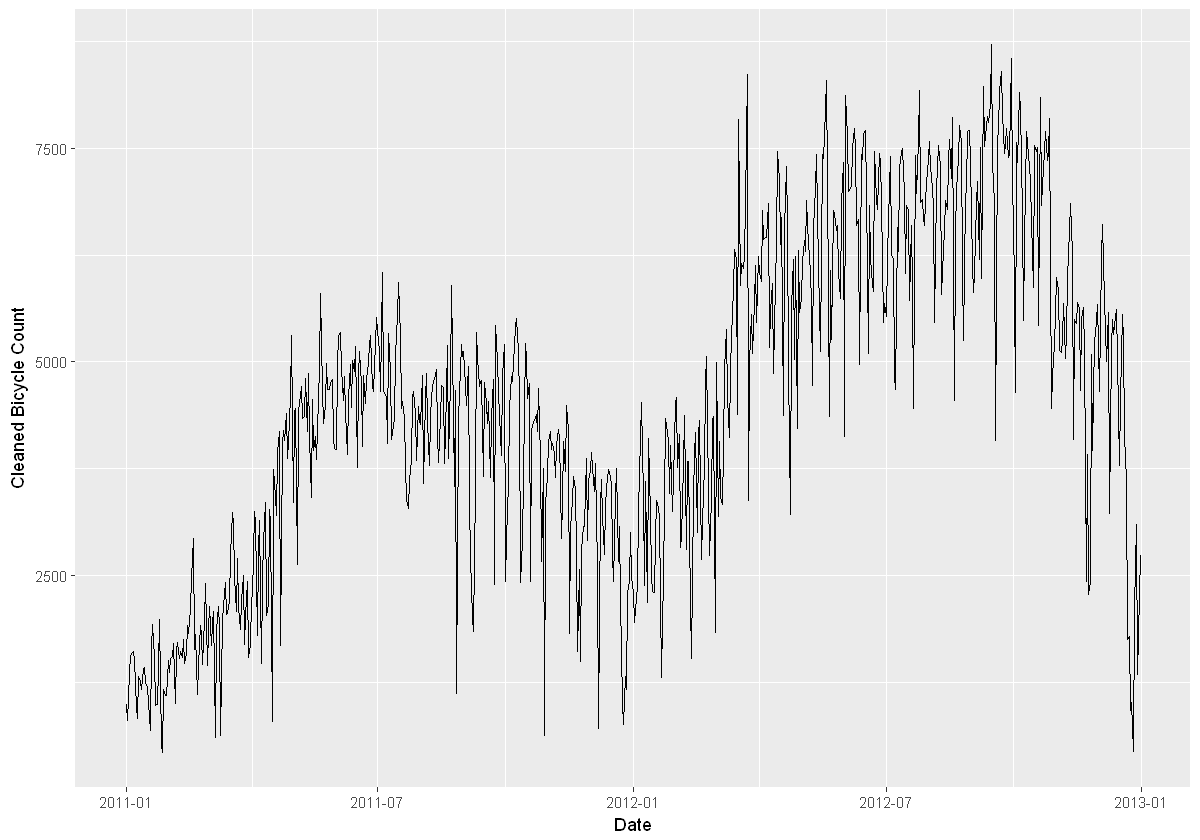

In [35]:
count_ts = ts(daily_data[, c('cnt')])

daily_data$clean_cnt = tsclean(count_ts)

options(repr.plot.width = 10, repr.plot.heights = 1)
ggplot() + geom_line(data = daily_data, aes(x = Date, y = clean_cnt)) + ylab('Cleaned Bicycle Count')

Even after removing outliers, the daily data is still pretty volatile. Visually, we could a draw a line through the series tracing its bigger troughs and peaks while smoothing out noisy fluctuations. This line can be described by one of the simplest — but also very useful —concepts in time series analysis known as a moving average. It is an intuitive concept that averages points across several time periods, thereby smoothing the observed data into a more stable predictable series.

Formally, a moving average (MA) of order m can be calculated by taking an average of series Y, k periods around each point:

$$ MA = \frac{1}{m} \sum^k_{j=-k} y_{t+j} $$

where m = 2k + 1. The above quantity is also called a symmetric moving average because data on each side of a point is involved in the calculation.

Note that the moving average in this context is distinct from the M A(q) component in the above ARIMA definition. Moving average M A(q) as part of the ARIMA framework refers to error lags and combinations, whereas the summary statistic of moving average refers to a data smoothing technique.

The wider the window of the moving average, the smoother original series becomes. In our bicycle example, we can take weekly or monthly moving average, smoothing the series into something more stable and therefore predictable:

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
Warning message:
"Removed 6 rows containing missing values (geom_path)."Warning message:
"Removed 30 rows containing missing values (geom_path)."

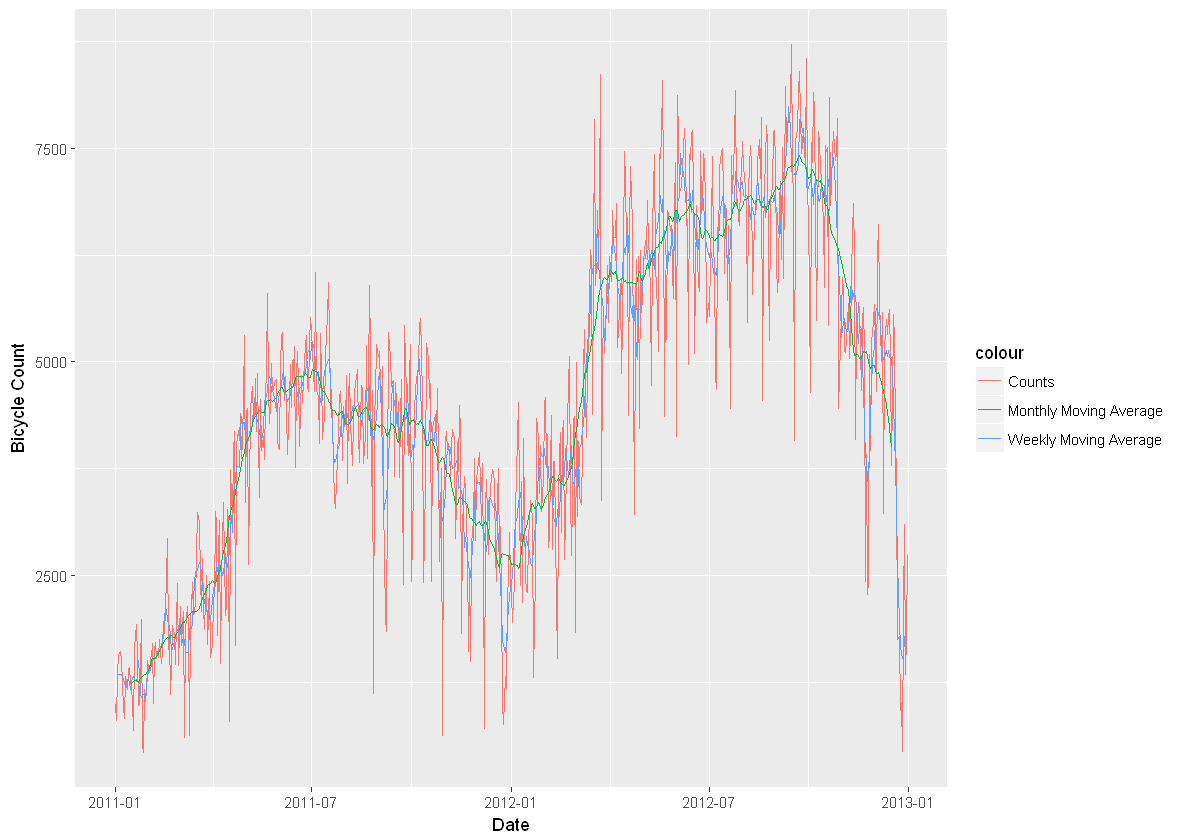

In [29]:
options(repr.plot.width = 10, repr.plot.heights = 2)
daily_data$cnt_ma = ma(daily_data$clean_cnt, order=7) # using the clean count with no outliers
daily_data$cnt_ma30 = ma(daily_data$clean_cnt, order=30)

ggplot() +
  geom_line(data = daily_data, aes(x = Date, y = clean_cnt, colour = "Counts")) +
  geom_line(data = daily_data, aes(x = Date, y = cnt_ma,   colour = "Weekly Moving Average"))  +
  geom_line(data = daily_data, aes(x = Date, y = cnt_ma30, colour = "Monthly Moving Average"))  +
  ylab('Bicycle Count')

In addition to volatility, modeling daily level data might require specifying multiple seasonality levels, such day of the week, week of the year, month of the year, holidays, etc. For the sake of simplicity, we will model the smoothed series of weekly moving average (as shown by the blue line above).

## Step 3: Decompose Your Data

The building blocks of a time series analysis are seasonality, trend, and cycle. These intuitive components capture the historical patterns in the series. Not every series will have all three (or any) of these components, but if they are present, deconstructing the series can help you understand its behavior and prepare a foundation for building a forecasting model.

**Seasonal component** refers to fluctuations in the data related to calendar cycles. For example, more people might be riding bikes in the summer and during warm weather, and less during colder months. Usually, seasonality is fixed at some number; for instance, quarter or month of the year.

**Trend component** is the overall pattern of the series: Is the number of bikes rented increasing or decreasing over time?

**Cycle component** consists of decreasing or increasing patterns that are not seasonal. Usually, trend and cycle components are grouped together. Trend-cycle component is estimated using moving averages.

Finally, part of the series that can't be attributed to seasonal, cycle, or trend components is referred to as **residual** or **error**.

The process of extracting these components is referred to as **decomposition**.

Formally, if Y is the number of bikes rented, we can decompose the series in two ways: by using either an additive or *multiplicative* model,

$$Y = S_t + T_t + E_t$$$$Y = S_t * T_t * E_t$$

where $S_t$ is the seasonal component, $T$ is trend and cycle, and $E$ is the remaining error.

An additive model is usually more appropriate when the seasonal or trend component is not proportional to the level of the series, as we can just overlay (i.e. add) components together to reconstruct the series. On the other hand, if the seasonality component changes with the level or trend of the series, a simple "overlay," or addition of components, won't be sufficient to reconstruct the series. In that case, a multiplicative model might be more appropriate.

As mentioned above, ARIMA models can be fitted to both seasonal and non-seasonal data. Seasonal ARIMA requires a more complicated specification of the model structure, although the process of determining $(P, D, Q)$ is similar to that of choosing non-seasonal order parameters. Therefore, we will explore how to de-seasonalize the series and use a "vanilla" non-seasonal ARIMA model.

First, we calculate seasonal component of the data using $stl()$. STL is a flexible function for decomposing and forecasting the series. It calculates the seasonal component of the series using smoothing, and adjusts the original series by subtracting seasonality in two simple lines:

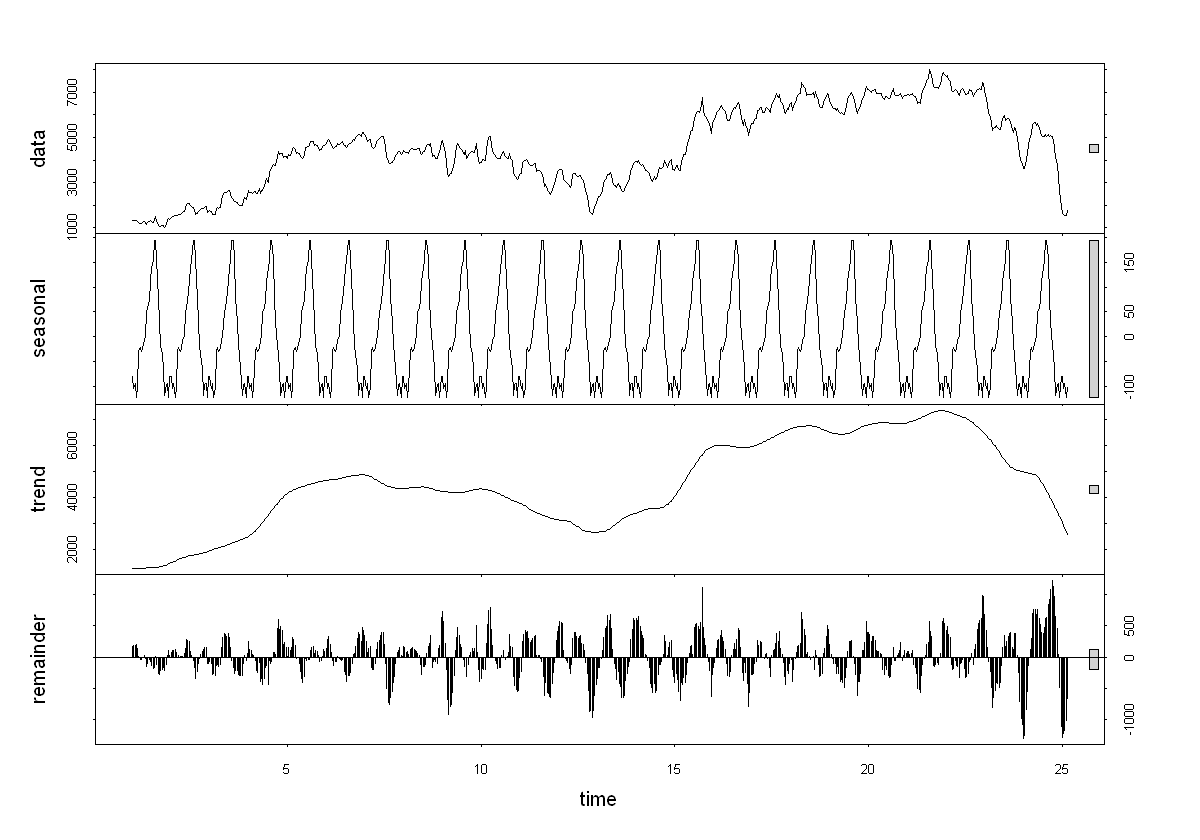

In [36]:
count_ma = ts(na.omit(daily_data$cnt_ma), frequency=30)
decomp = stl(count_ma, s.window="periodic")
deseasonal_cnt <- seasadj(decomp)
plot(decomp)

Note that $stl()$ by default assumes additive model structure. Use **allow.multiplicative.trend=TRUE** to incorporate the multiplicative model.

In the case of additive model structure, the same task of decomposing the series and removing the seasonality can be accomplished by simply subtracting the seasonal component from the original series. **seasadj()** is a convenient method inside the **forecast** package.

As for the frequency parameter in **ts()** object, we are specifying periodicity of the data, i.e., number of observations per period. Since we are using smoothed daily data, we have 30 observations per month.

We now have a de-seasonalized series and can proceed to the next step.

## Step 4: Stationarity

Fitting an ARIMA model requires the series to be stationary. A series is said to be stationary when its mean, variance, and autocovariance are time invariant. This assumption makes intuitive sense: Since ARIMA uses previous lags of series to model its behavior, modeling stable series with consistent properties involves less uncertainty. The left panel below shows an example of a stationary series, where data values oscillate with a steady variance around the mean of 1. The panel on the right shows a non-stationary series; mean of this series will differ across different time windows.

![](https://www.datascience.com/hs-fs/hubfs/learn-data-science-forecasting-with-ARIMA-chart5.png?t=1495066237301&width=760&height=380&name=learn-data-science-forecasting-with-ARIMA-chart5.png)

The augmented Dickey-Fuller (ADF) test is a formal statistical test for stationarity. The null hypothesis assumes that the series is non-stationary. ADF procedure tests whether the change in Y can be explained by lagged value and a linear trend. If contribution of the lagged value to the change in Y is non-significant and there is a presence of a trend component, the series is non-stationary and null hypothesis will not be rejected.

Our bicycle data is non-stationary; the average number of bike checkouts changes through time, levels change, etc. A formal ADF test does not reject the null hypothesis of non-stationarity, confirming our visual inspection: 

In [42]:
adf.test(count_ma, alternative = "stationary")

Warning message in adf.test(count_ma, alternative = "stationary"):
"p-value greater than printed p-value"


	Augmented Dickey-Fuller Test

data:  count_ma
Dickey-Fuller = -0.2557, Lag order = 8, p-value = 0.99
alternative hypothesis: stationary


Usually, non-stationary series can be corrected by a simple transformation such as differencing. Differencing the series can help in removing its trend or cycles. The idea behind differencing is that, if the original data series does not have constant properties over time, then the change from one period to another might. The difference is calculated by subtracting one period's values from the previous period's values:

$$Y_{d_t} = Y_t - Y_{t-1}$$
 

Higher order differences are calculated in a similar fashion. For example, second order differencing (d = 2) is simply expanded to include second lag of the series:

$$Y_{d2_t} = Y_{d_t} - Y_{d_t-1} = (Y_t - Y_{t-1}) - (Y_{t-1} - Y_{t-2})$$
 

Similarly, differencing can be used if there is a seasonal pattern at specific lags. In such a case, subtracting a value for the "season" from a previous period represents the change from one period to another, as well as from one season to another:

$$Y_{d_t} = (Y_t - Y_{t-s}) - (Y_{t-1} - Y_{t-s-1} )$$
 

The number of differences performed is represented by the d component of ARIMA. Now, we move on to diagnostics that can help determine the order of differencing.

## Step 5: Autocorrelations and Choosing Model Order

Autocorrelation plots (also known as ACF or the auto correlation function) are a useful visual tool in determining whether a series is stationary. These plots can also help to choose the order parameters for ARIMA model. If the series is correlated with its lags then, generally, there are some trend or seasonal components and therefore its statistical properties are not constant over time.

ACF plots display correlation between a series and its lags. In addition to suggesting the order of differencing, ACF plots can help in determining the order of the M A (q) model. Partial autocorrelation plots (PACF), as the name suggests, display correlation between a variable and its lags that is not explained by previous lags. PACF plots are useful when determining the order of the AR(p) model.

R plots 95% significance boundaries as blue dotted lines. There are significant autocorrelations with many lags in our bike series, as shown by the ACF plot below. However, this could be due to carry-over correlation from the first or early lags, since the PACF plot only shows a spike at lags 1 and 7: 

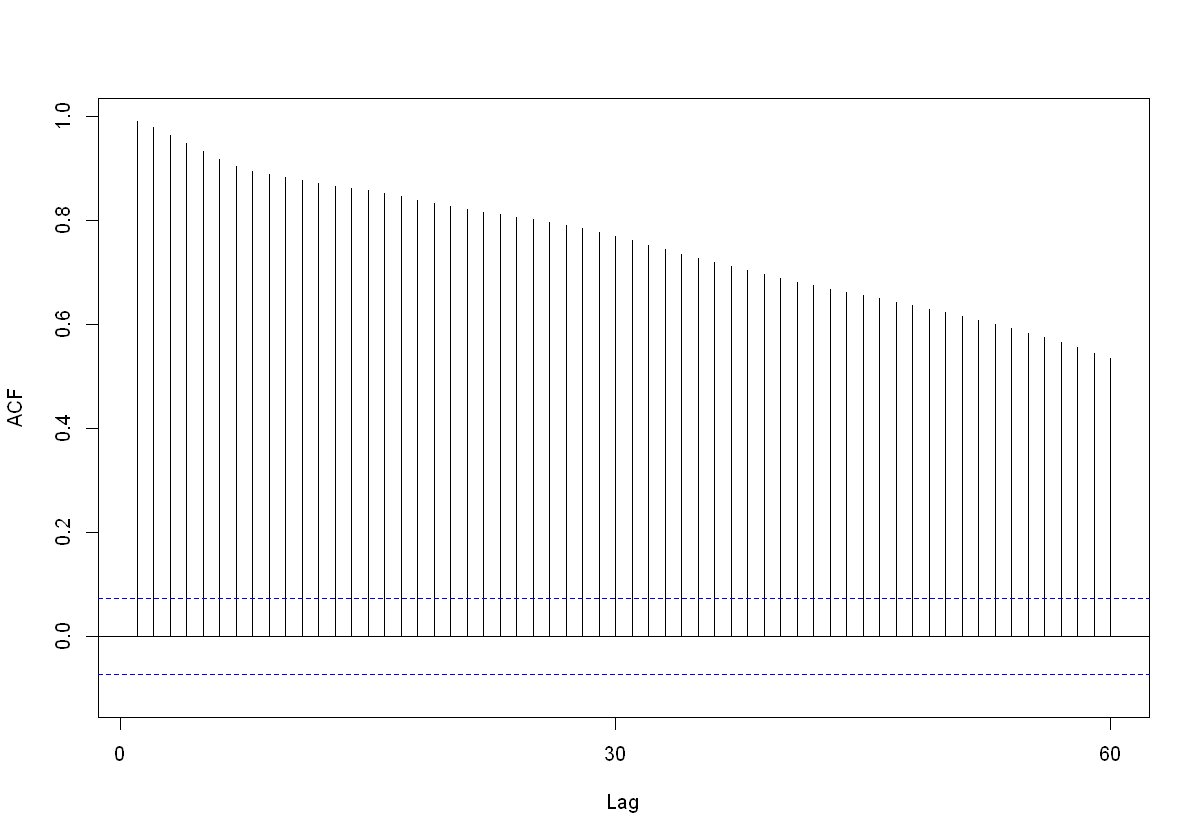

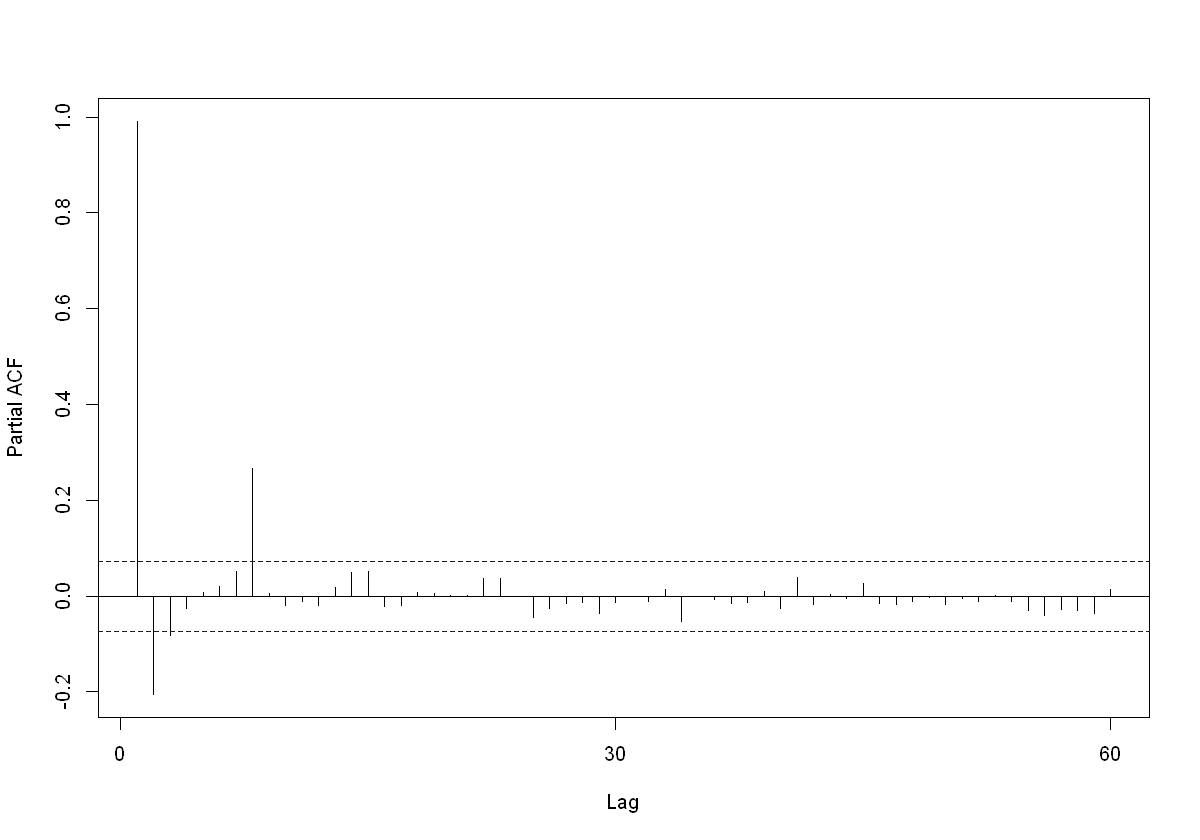

In [39]:
options(repr.plot.width = 10, repr.plot.heights = 1)
Acf(count_ma, main='')

Pacf(count_ma, main='')


We can start with the order of d = 1 and re-evaluate whether further differencing is needed.

The augmented Dickey-Fuller test on differenced data rejects the null hypotheses of non-stationarity. Plotting the differenced series, we see an oscillating pattern around 0 with no visible strong trend. This suggests that differencing of order 1 terms is sufficient and should be included in the model. 

Warning message in adf.test(count_d1, alternative = "stationary"):
"p-value smaller than printed p-value"


	Augmented Dickey-Fuller Test

data:  count_d1
Dickey-Fuller = -9.9255, Lag order = 8, p-value = 0.01
alternative hypothesis: stationary


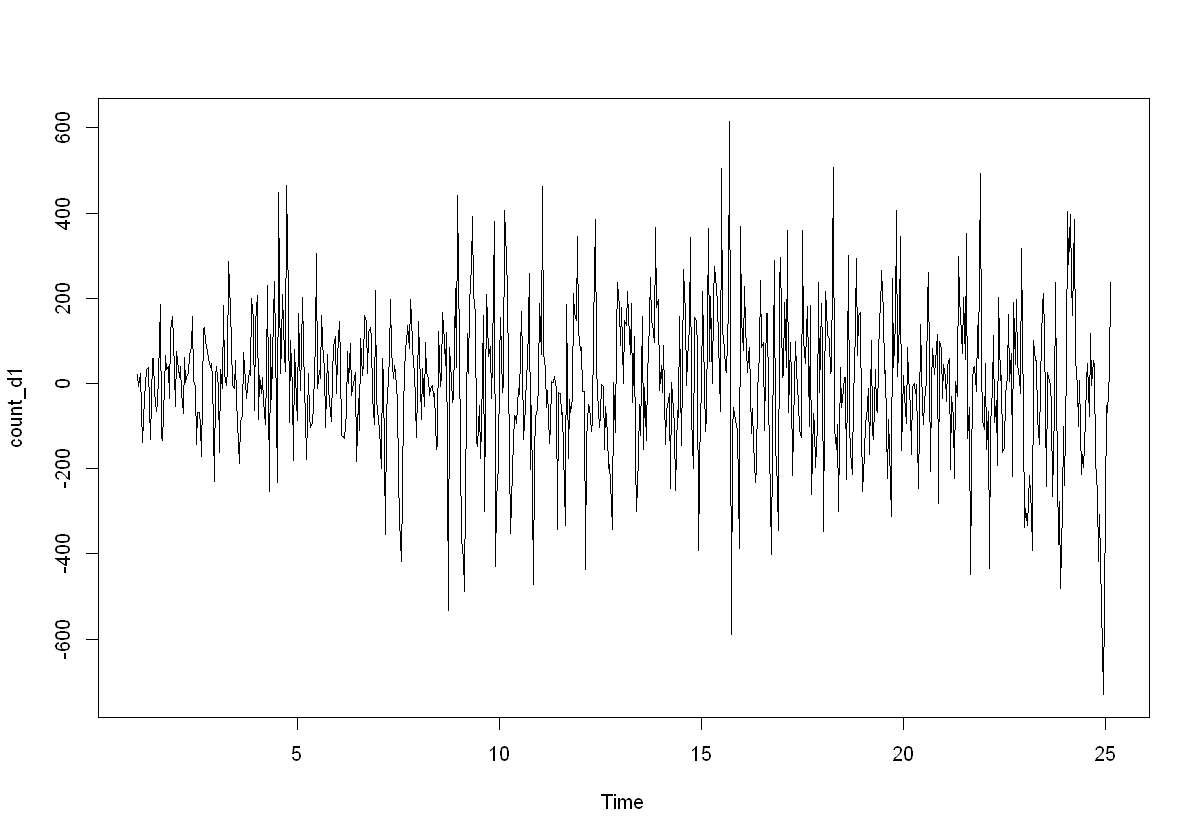

In [41]:
count_d1 = diff(deseasonal_cnt, differences = 1)
plot(count_d1)
adf.test(count_d1, alternative = "stationary")